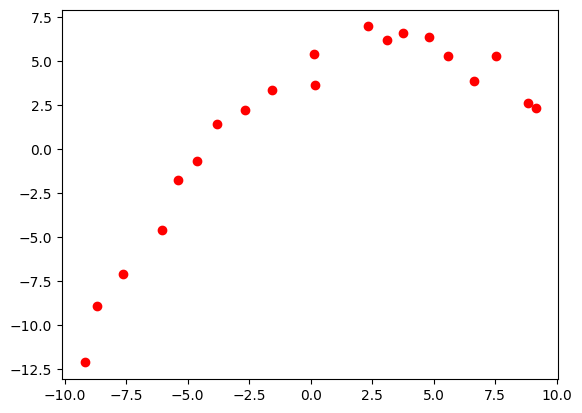

In [2]:
#1-1
import numpy as np
import matplotlib.pyplot as plt

def f(x,a,b,c):
  return a*x**2+b*x+c

a,b,c, = -0.1,0.7,5
x = np.linspace(-10,10,20)
y = f(x,a,b,c)
xn = x + 0.5*np.random.normal(size=len(x))
yn = y + 0.5*np.random.normal(size=len(y))

plt.plot(xn, yn, 'or')
plt.show()

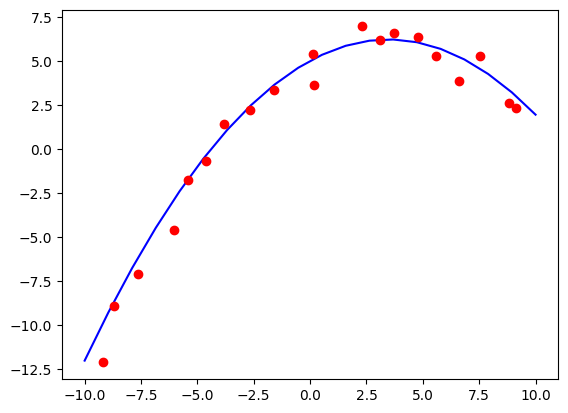

원래 (a,b,c) = (-0.1, 0.7, 5)
추정된 (a,b,c) = (-0.101, 0.700, 5.015)


In [3]:
#1-2
An = np.vstack([x*x, x, np.ones(len(x))]).T
abcn = np.dot(np.linalg.inv(np.dot(An.T, An)), np.dot(An.T, yn))
plt.plot(x, f(x,abcn[0],abcn[1] ,abcn[2]), '-b')
plt.plot(xn,yn,'or')
plt.show()

print(f"원래 (a,b,c) = ({a}, {b}, {c})")
print(f"추정된 (a,b,c) = ({abcn[0]:.3f}, {abcn[1]:.3f}, {abcn[2]:.3f})")

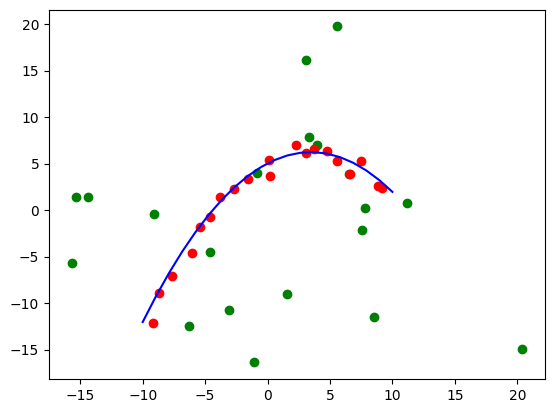

In [4]:
#1-3
xo = 10*np.random.normal(size=len(x))
yo = 10*np.random.normal(size=len(x))

plt.plot(xo,yo,'og')
plt.plot(xn,yn,'or')
plt.plot(x, f(x,abcn[0],abcn[1] ,abcn[2]), '-b')
plt.show()

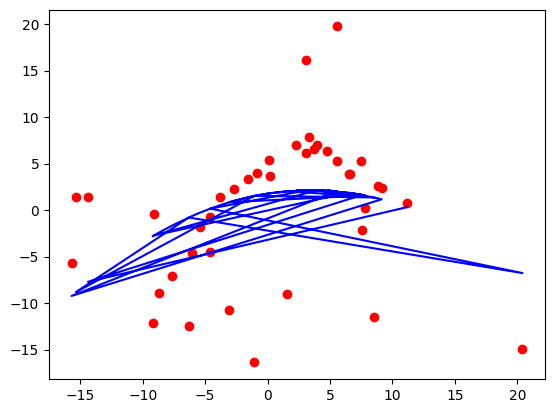

원래 (a,b,c) = (-0.1, 0.7, 5)
추정된 (a,b,c) = (-0.031, 0.214, 1.788)


In [5]:
#1-4
xno = np.concatenate((xn,xo))
yno = np.concatenate((yn,yo))

An = np.vstack([xno*xno, xno, np.ones(len(xno))]).T
abcno = np.dot(np.linalg.inv(np.dot(An.T, An)), np.dot(An.T, yno))

plt.plot(xno, yno, 'or')
plt.plot(xno, f(xno,abcno[0],abcno[1] ,abcno[2]), '-b')
plt.show()

print(f"원래 (a,b,c) = ({a}, {b}, {c})")
print(f"추정된 (a,b,c) = ({abcno[0]:.3f}, {abcno[1]:.3f}, {abcno[2]:.3f})")

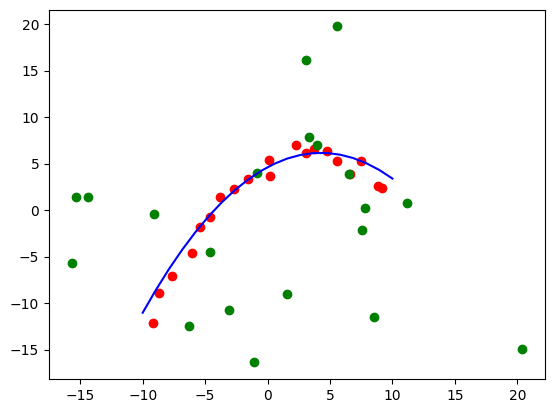

원래 (a,b,c) = (-0.1, 0.7, 5)
추정된 (a,b,c) = (-0.084, 0.721, 4.609)


In [6]:
#1-5
def ransac_curve_fiting(x,y,r,t):
  iter = np.round(np.log(1-0.999) / np.log(1-(1-r)**3) + 1)
  abc_max = None
  num_max = 0

  for i in np.arange(iter):
    id = np.random.permutation(len(x))
    xs = x[id[:3]]
    ys = y[id[:3]]

    A = np.vstack([xs**2, xs, np.ones(len(xs))]).T
    abc = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, ys))

    #이차곡선까지의 실제 거리 구하는 연산이 복잡하여 y값 차이로 거리를 계산하였음
    y_pred = abc[0]*x**2 + abc[1]*x + abc[2]
    dist = np.abs(y - y_pred)

    numInliers = sum(dist < t)

    if numInliers > num_max:
      abc_max = abc
      num_max = numInliers

  return abc_max, num_max

abcno_ransac, max = ransac_curve_fiting(xno, yno, 0.5, 2)

plt.plot(xn, yn, 'or')
plt.plot(xo, yo,'og')
plt.plot(x, f(x,abcno_ransac[0],abcno_ransac[1],abcno_ransac[2]), '-b')
plt.show()

print(f"원래 (a,b,c) = ({a}, {b}, {c})")
print(f"추정된 (a,b,c) = ({abcno_ransac[0]:.3f}, {abcno_ransac[1]:.3f}, {abcno_ransac[2]:.3f})")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


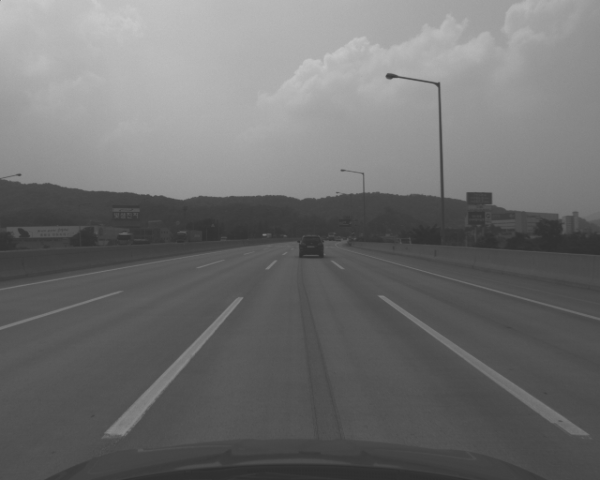

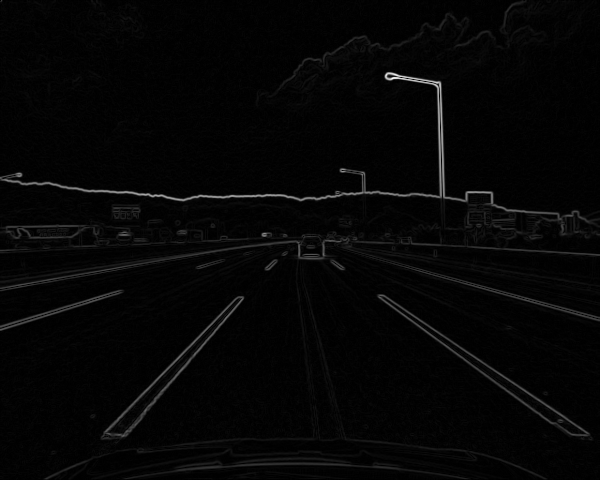

In [15]:
#2-1
import cv2 as cv
import numpy as np
from google.colab.patches import cv_imshow

from google.colab import drive
drive.mount('/content/gdrive')
img = cv.imread('gdrive/MyDrive/MachineVision/samples/lanes.bmp',cv.IMREAD_GRAYSCALE)

Ix = cv.Sobel(img,ddepth=cv.CV_64F,dx=1,dy=0,ksize=3)
Iy = cv.Sobel(img,ddepth=cv.CV_64F,dx=0,dy=1,ksize=3)
mag = np.sqrt(np.square(Ix) + np.square(Iy))
ori = np.arctan2(Iy,Ix) * 180/np.pi

Ix_ = (Ix-Ix.min()) / (Ix.max()-Ix.min()) * 255
Iy_ = (Iy-Iy.min()) / (Iy.max()-Iy.min()) * 255
mag_ = (mag-mag.min()) / (mag.max()-mag.min()) * 255
ori_ = (ori-ori.min()) / (ori.max()-ori.min()) * 255

cv_imshow(img)
cv_imshow(mag_)
#cv_imshow(ori_)

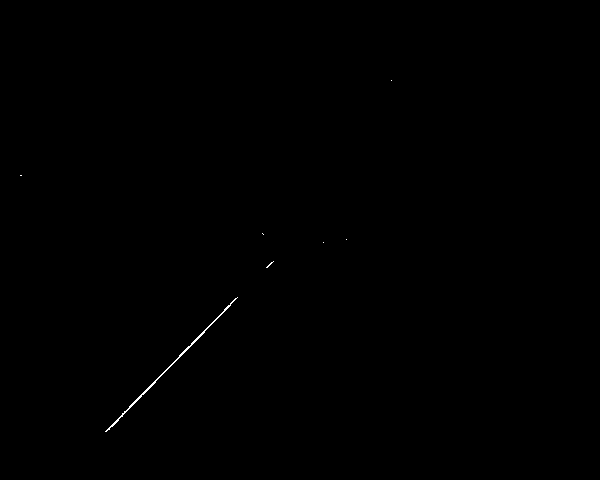

In [16]:
#2-2
result_left = np.zeros(img.shape)
id_left = np.where((mag>100) & (ori>30) & (ori<60))
result_left[id_left] = 255
cv_imshow(result_left)

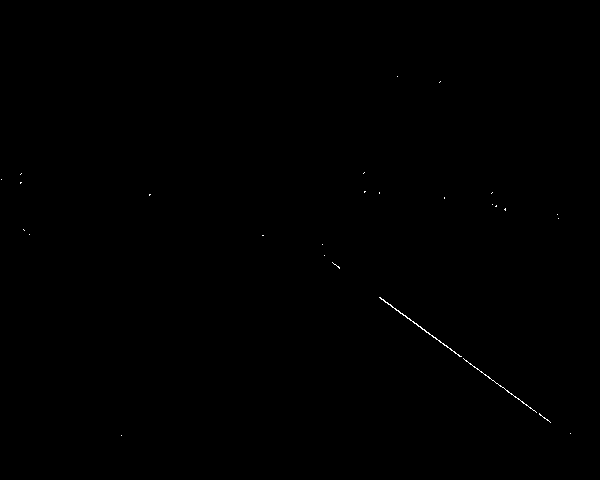

In [17]:
#2-3
result_right = np.zeros(img.shape)
id_right = np.where((mag>100) & (ori>-60) & (ori<-30))
result_right[id_right] = 255
cv_imshow(result_right)

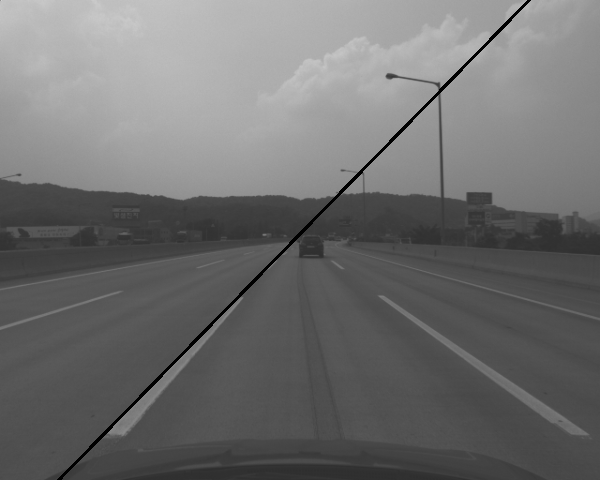

In [18]:
#3-1
def ransac_line_fiting(x,y,r,t):
  iter = np.round(np.log(1-0.999) / np.log(1-(1-r)**2) + 1)
  num_max = 0
  for i in np.arange(iter):
    id = np.random.permutation(len(x))
    xs = x[id[:2]]
    ys = y[id[:2]]
    A = np.vstack([xs, np.ones(len(xs))]).T
    ab = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, ys))
    dist = np.abs(ab[0]*x-y+ab[1])/np.sqrt(ab[0]**2+1)
    numInliers = sum(dist < t)
    if numInliers > num_max:
      ab_max = ab
      num_max = numInliers
  return ab_max, num_max

img = cv.imread('gdrive/MyDrive/MachineVision/samples/lanes.bmp',cv.IMREAD_GRAYSCALE)
height, width = img.shape[:2]

img_left = img.copy()
ab_max, num_max = ransac_line_fiting(id_left[1],id_left[0],0.5,2)
a_max, b_max = ab_max
point1 = (0, int(b_max))
point2 = (width, int(a_max*width+b_max))
cv.line(img_left, point1, point2, (0,0,255), 2)
cv_imshow(img_left)

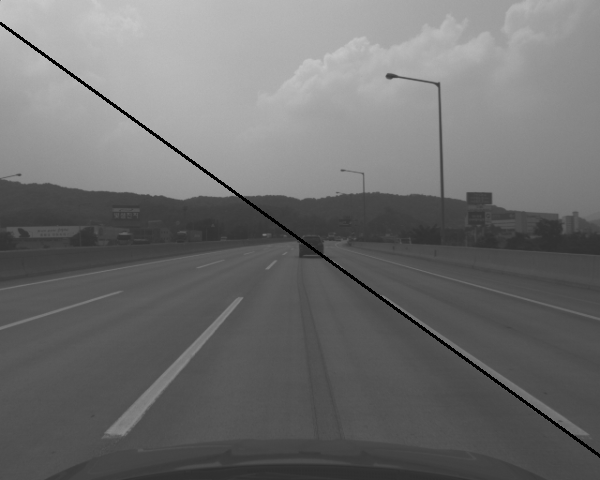

In [19]:
#3-2
img_right = img.copy()
ab_max, num_max = ransac_line_fiting(id_right[1],id_right[0],0.5,2)
a_max, b_max = ab_max
point1 = (0, int(b_max))
point2 = (width, int(a_max*width+b_max))
cv.line(img_right, point1, point2, (0,0,255), 2)
cv_imshow(img_right)

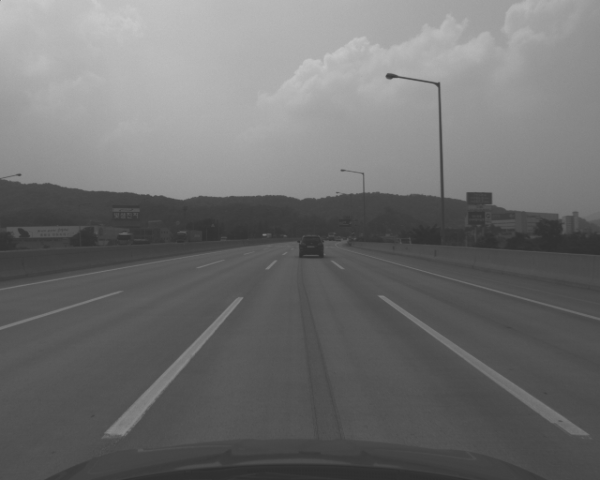

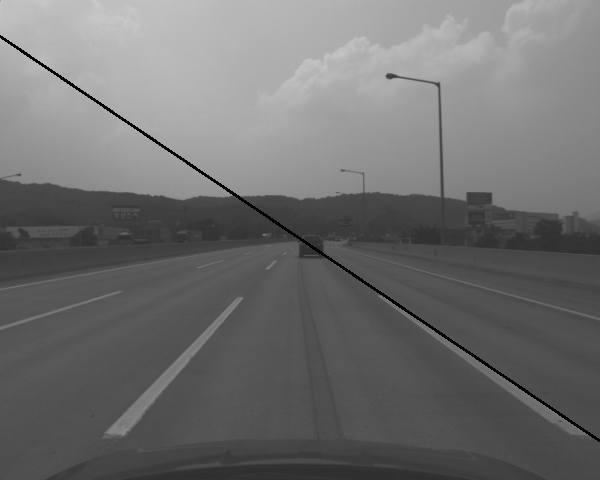

In [20]:
#4-1
img = cv.imread('gdrive/MyDrive/MachineVision/samples/lanes.bmp',cv.IMREAD_GRAYSCALE)

edges = cv.Canny(img,50,150)

lines = cv.HoughLines(image=edges,rho=1,theta=np.pi/180,threshold=200)
img_withlines = img.copy()
for line in lines:
  rho,theta = line[0]
  cosine = np.cos(theta)
  sine = np.sin(theta)
  x0 = rho * cosine
  y0 = rho * sine
  vec0 = [-sine, cosine]
  vec1 = [sine, -cosine]
  x1 = int(x0 + 1000*vec0[0])
  y1 = int(y0 + 1000*vec0[1])
  x2 = int(x0 + 1000*vec1[0])
  y2 = int(y0 + 1000*vec1[1])
  cv.line(img_withlines,(x1,y1),(x2,y2),(0,0,255),2)

cv_imshow(img)
cv_imshow(img_withlines)

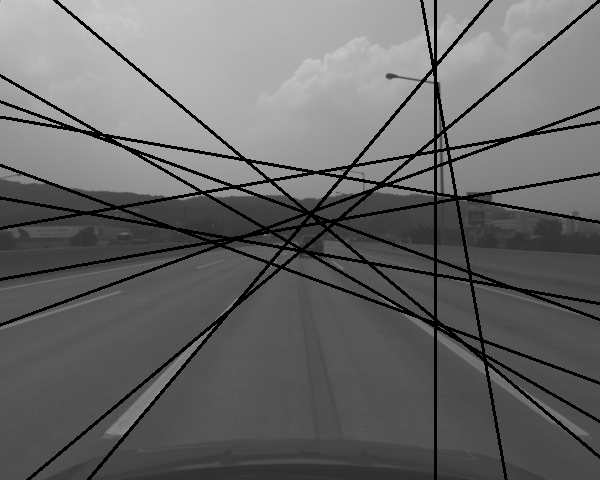

In [21]:
#4-2
img = cv.imread('gdrive/MyDrive/MachineVision/samples/lanes.bmp',cv.IMREAD_GRAYSCALE)

edges = cv.Canny(img,50,150)

lines = cv.HoughLines(image=edges,rho=1*10,theta=np.pi/180*10,threshold=200)
img_withlines = img.copy()
for line in lines:
  rho,theta = line[0]
  cosine = np.cos(theta)
  sine = np.sin(theta)
  x0 = rho * cosine
  y0 = rho * sine
  vec0 = [-sine, cosine]
  vec1 = [sine, -cosine]
  x1 = int(x0 + 1000*vec0[0])
  y1 = int(y0 + 1000*vec0[1])
  x2 = int(x0 + 1000*vec1[0])
  y2 = int(y0 + 1000*vec1[1])
  cv.line(img_withlines,(x1,y1),(x2,y2),(0,0,255),2)

cv_imshow(img_withlines)

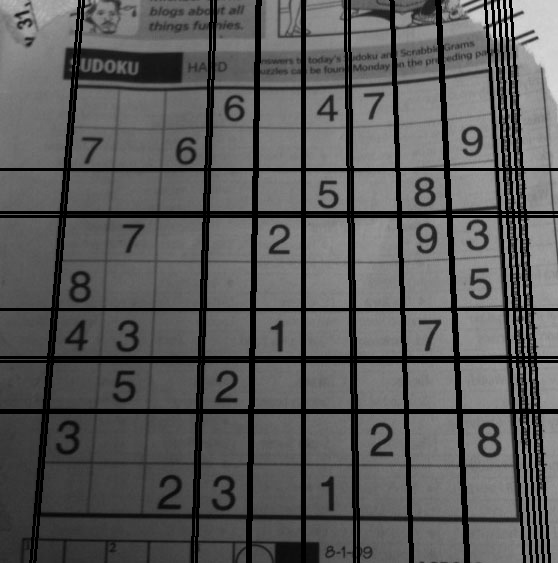

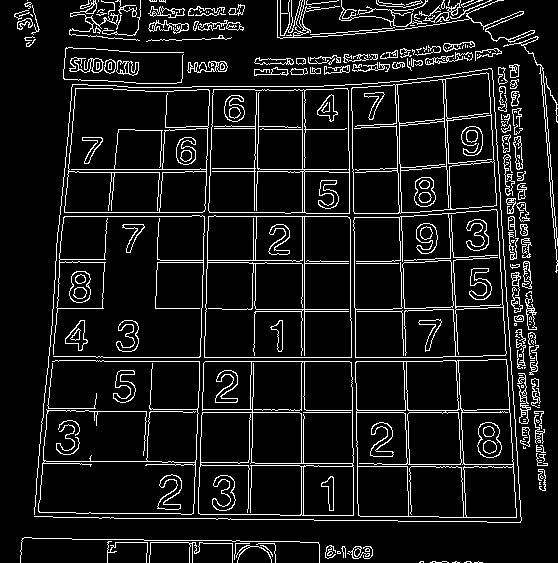

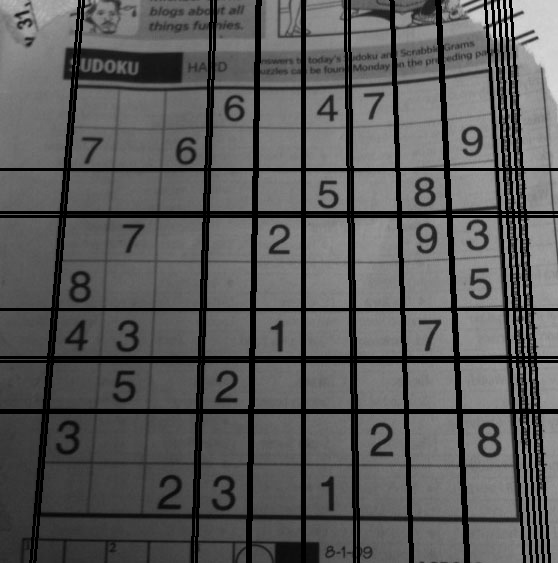

In [24]:
gray = cv.imread('gdrive/MyDrive/MachineVision/samples/sudoku.png',cv.IMREAD_GRAYSCALE)

edges = cv.Canny(gray,50,150)
lines = cv.HoughLines(image=edges,rho=1,theta=np.pi/180,threshold=200)
for line in lines:
  rho,theta = line[0]
  cosine = np.cos(theta); sine = np.sin(theta)
  x0 = rho*cosine; y0 = rho*sine
  vec0 = [-sine,cosine]; vec1 = [sine,-cosine]
  x1 = int(x0 + 1000*vec0[0])
  y1 = int(y0 + 1000*vec0[1])
  x2 = int(x0 + 1000*vec1[0])
  y2 = int(y0 + 1000*vec1[1])
  cv.line(gray,(x1,y1),(x2,y2),(0,0,255),2)

cv_imshow(gray)
cv_imshow(edges)
cv_imshow(gray)